# Train Pion Stop Regressor


In [1]:
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines.training import pion_stop_optuna_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
# Configure the pipeline
# Use absolute path based on project root
# All models use the same source data: mainTimeGroups_*.npy
file_pattern = str(Path(PROJECT_ROOT) / 'data' / 'mainTimeGroups_*.npy')
run = pion_stop_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        # Data loading parameters
        'file_pattern': file_pattern,
        'max_files': 1,              # Limit number of files to load
        'limit_groups': 1000,       # Cap total groups for quicker iterations
        'min_hits': 2,
        # Datamodule parameters
        'batch_size': 128,
        'num_workers': None,         # None = auto-detect (uses #CPU cores - 1)
                                     # Set to 0 to disable multiprocessing
                                     # Set to a specific number to override
        'val_split': 0.15,
        'seed': 42,
    },
    run_hparam_search_params={
        'n_trials': 1,               # Optuna trials for the search step
        'max_epochs': 1,             # epochs per trial during search
        'limit_train_batches': 0.4,   # fraction/int of train batches per trial
        'limit_val_batches': 1.0,     # fraction/int of val batches per trial
    },
    train_best_model_params={
        'max_epochs': 5,             # final training epochs cap
        'early_stopping': True,        # enable early stopping
        'early_stopping_patience': 6, # patience for early stopping
        'early_stopping_monitor': 'val_loss',
        'early_stopping_mode': 'min',
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: pion_stop_optuna_pipeline.
Caching is disabled by default for pion_stop_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_pion_stop_datamodule has started.


[build_pion_stop_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_pion_stop_datamodule] Starting to load data from: /home/jack/python_projects/pioneerML/data/mainTimeGroups_*.npy
[build_pion_stop_datamodule] Limiting to 1 files (from 11 total files found, max_files=1)
[build_pion_stop_datamodule] Loaded 1000 groups. Building datamodule...
[build_pion_stop_datamodule] Calling setup(stage='fit')...
[build_pion_stop_datamodule] Setup complete. Train: 850, Val: 150


[build_pion_stop_datamodule] Loaded 1000 pion groups across 1 files | total groups=1000 kept=1000 | total pion hits=28401
Step build_pion_stop_datamodule has finished in 0.370s.
Step run_pion_stop_hparam_search has started.


[run_pion_stop_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_pion_stop_hparam_search] CUDA devices: 1
[run_pion_stop_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_pion_stop_hparam_search] Dataset sizes - Train: 850, Val: 150
[run_pion_stop_hparam_search] Starting Optuna search with 1 trials, 1 epochs per trial...
[I 2025-12-05 13:45:15,015] A new study created in memory with name: no-name-c60ead04-b796-467d-a06e-d1830b07a9d1
[run_pion_stop_hparam_search] Starting Optuna study...


  0%|          | 0/1 [00:00<?, ?it/s]

[run_pion_stop_hparam_search] Trial 1/1 starting...
[run_pion_stop_hparam_search] Trial 1 params: batch_size=16, hidden=192 (from 192), heads=8, layers=3, dropout=0.0670, lr=0.007098, weight_decay=0.000017
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_pion_stop_hparam_search] Trial 1 training 1 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor │  1.6 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.6 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 62                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


[run_pion_stop_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_pion_stop_hparam_search] Trial 1 completed with score: 0.126626
[run_pion_stop_hparam_search] Optuna search complete! Best score: 0.126626
[run_pion_stop_hparam_search] Best params: {'batch_size': 16, 'hidden': 192, 'heads': 8, 'layers': 3, 'dropout': 0.06701268614991118, 'lr': 0.0070984819859463135, 'weight_decay': 1.7036538595097904e-05}


[I 2025-12-05 13:45:19,573] Trial 0 finished with value: 0.12662600276057284 and parameters: {'batch_size': 16, 'hidden': 192, 'heads': 8, 'layers': 3, 'dropout': 0.06701268614991118, 'lr': 0.0070984819859463135, 'weight_decay': 1.7036538595097904e-05}. Best is trial 0 with value: 0.12662600276057284.
Step run_pion_stop_hparam_search has finished in 4.697s.
Step train_best_pion_stop_regressor has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor │  1.6 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.6 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 62                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Step train_best_pion_stop_regressor has finished in 14.985s.
Step collect_pion_stop_predictions has started.
Step collect_pion_stop_predictions has finished in 1.913s.
Pipeline run has finished in 25.021s.
Run name: pion_stop_optuna_pipeline-2025_12_05-18_45_13_791139
Run status: completed


In [3]:
# Load artifacts from the pipeline run
trained_module = load_step_output(run, "train_best_pion_stop_regressor")
datamodule = load_step_output(run, "build_pion_stop_datamodule")
predictions = load_step_output(run, "collect_pion_stop_predictions", index=0)
targets = load_step_output(run, "collect_pion_stop_predictions", index=1)
best_params = load_step_output(run, "run_pion_stop_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")
print("Best params from Optuna:", best_params)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))



Loaded module on cpu; validation samples: 150
Best params from Optuna: {'batch_size': 16, 'hidden': 192, 'heads': 8, 'layers': 3, 'dropout': 0.06701268614991118, 'lr': 0.0070984819859463135, 'weight_decay': 1.7036538595097904e-05, 'best_score': 0.12662600276057284, 'n_trials': 1} {'batch_size': 16, 'hidden': 192, 'heads': 8, 'layers': 3, 'dropout': 0.06701268614991118, 'lr': 0.0070984819859463135, 'weight_decay': 1.7036538595097904e-05, 'best_score': 0.12662600276057284, 'n_trials': 1}
Epochs actually run: 6 6


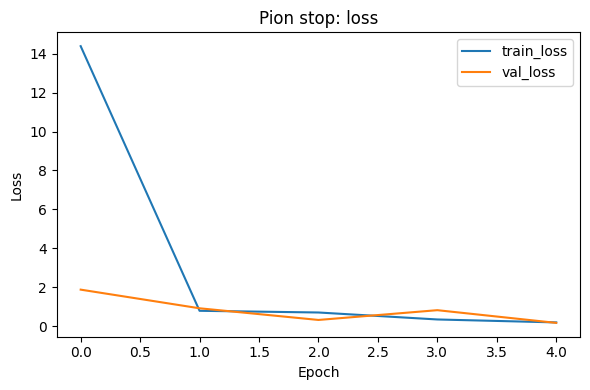

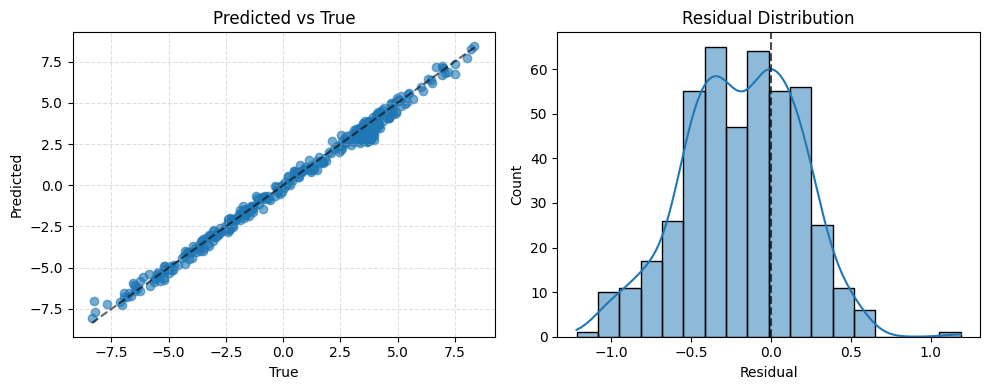

In [4]:
from pioneerml.evaluation.plots import plot_loss_curves, plot_regression_diagnostics

# Loss curves
plot_loss_curves(trained_module, title="Pion stop: loss", show=True)

# Regression diagnostics
plot_regression_diagnostics(predictions=predictions, targets=targets, show=True)


In [5]:
# Save trained pion stop model checkpoint
from datetime import datetime
import torch

ckpt_dir = Path(PROJECT_ROOT) / "trained_models" / "pion_stop"
ckpt_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ckpt_path = ckpt_dir / f"pion_stop_{timestamp}.pt"
#torch.save(trained_module.model.state_dict(), ckpt_path)
print(f"Saved checkpoint to {ckpt_path}")


Saved checkpoint to /home/jack/python_projects/pioneerML/trained_models/pion_stop/pion_stop_20251205_134540.pt
